# Préparation & preprocessing

In [3]:
# Import lib
import os, urllib.request, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Dataset
df = "WA_Fn-UseC_-HR-Employee-Attrition.csv"

# Chargement + nettoyage léger
drop_cols = [c for c in ["EmployeeCount","Over18","StandardHours","EmployeeNumber"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Split features / cible
y = df["YearsAtCompany"].values
X = df.drop(columns=["YearsAtCompany"])

# Colonnes catégorielles / numériques
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Préprocessing
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # compat anciennes versions

prepro = ColumnTransformer([
    ("cat", ohe, cat_cols),
    ("num", StandardScaler(), num_cols)
])

print(f"X: {X.shape}, y mean={y.mean():.1f}")

X: (1470, 30), y mean=7.0


# Choix du modèle : LinReg, Tree, RF

In [4]:
#import lib
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def mape_safe(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.abs(y_true) > eps
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))) if mask.sum() else np.nan

np.random.seed(42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Les 3 modèles à tester
models = {
    "LinReg": LinearRegression(),
    "Tree":   DecisionTreeRegressor(random_state=42),
    "RF":     RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
}

rows, oof_preds = [], {}
for name, reg in models.items():
    pipe = Pipeline([("prep", prepro), ("reg", reg)])
    yhat_oof = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1, method="predict")
    oof_preds[name] = yhat_oof

    mae  = mean_absolute_error(y, yhat_oof)
    r2   = r2_score(y, yhat_oof)
    mape = mape_safe(y, yhat_oof) * 100

    rows.append({"Model": name, "MAE": round(mae,2), "R²": round(r2,3), "MAPE (%)": round(mape,2)})

# Tableau final trié du meilleur au moins bon
scores = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)
scores

,Model,MAE,R²,MAPE (%)
0,RF,0.85,0.925,14.29
1,Tree,1.06,0.828,17.63
2,LinReg,1.95,0.763,43.08


# Comprendre les résultats avec un graphique

✅ Modèle retenu (CV): RF


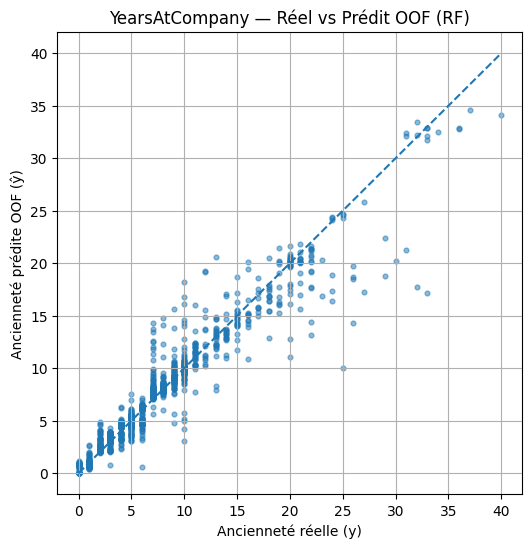

In [5]:
# Montre si le modèle colle bien aux valeurs.

best_name = scores.iloc[0]["Model"]
yhat_best = oof_preds[best_name]

print(f"✅ Modèle retenu (CV): {best_name}")

plt.figure(figsize=(6,6))
plt.scatter(y, yhat_best, s=12, alpha=0.5)
minv, maxv = float(min(y.min(), yhat_best.min())), float(max(y.max(), yhat_best.max()))
plt.plot([minv,maxv],[minv,maxv],'--')
plt.xlabel("Ancienneté réelle (y)")
plt.ylabel("Ancienneté prédite OOF (ŷ)")
plt.title(f"YearsAtCompany — Réel vs Prédit OOF ({best_name})")
plt.grid(True)
plt.show()

# Explicabilité SHAP

 99%|===================| 1459/1470 [02:12<00:00]       

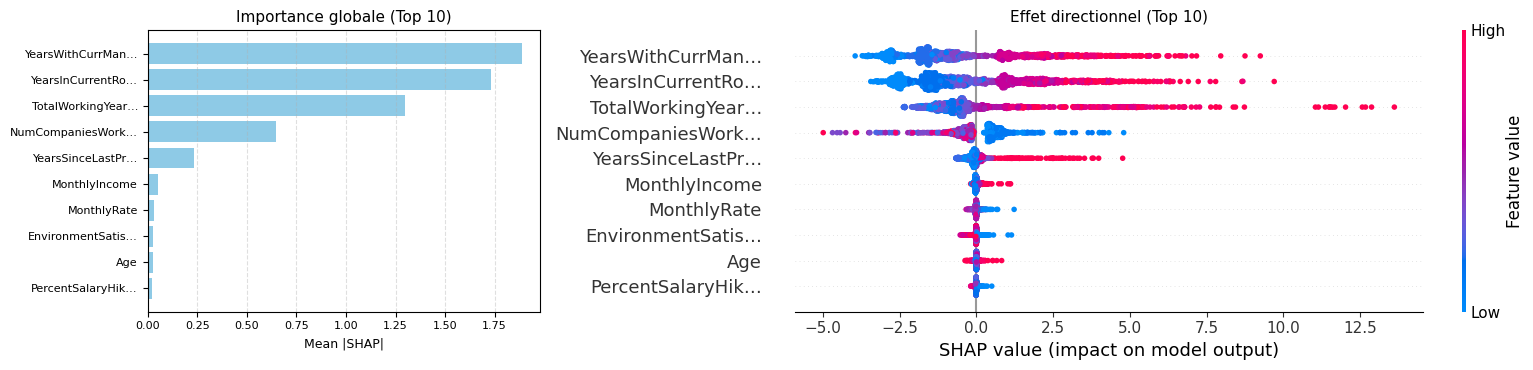

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# Refit du meilleur modèle sur tout X,y
best_pipe = Pipeline([("prep", prepro), ("reg", models[best_name])])
best_pipe.fit(X, y)

Xmat = prepro.fit_transform(X)
feat_names = np.array(prepro.get_feature_names_out())

# Explication SHAP
explainer = shap.Explainer(best_pipe.named_steps["reg"], Xmat, feature_names=feat_names)
shap_values = explainer(Xmat, check_additivity=False)

# Top 10 (moyenne des |SHAP|)
vals = np.asarray(shap_values.values)
if vals.ndim == 1:
    vals = vals.reshape(-1, 1)
mean_abs = np.abs(vals).mean(axis=0)
top_idx   = np.argsort(-mean_abs)[:10]
top_feats = feat_names[top_idx]
top_vals  = mean_abs[top_idx]

def clean_label(name, maxlen=16):
    name = name.replace("cat__", "").replace("num__", "")
    return (name[:maxlen] + "…") if len(name) > maxlen else name

labels = [clean_label(f) for f in top_feats]

# Mise en page
plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

fig, ax = plt.subplots(
    1, 2, figsize=(16, 3.8),  # large & peu haut
    gridspec_kw={"width_ratios": [1.1, 2.2]}  # beeswarm plus large
)

ypos = np.arange(len(top_feats))
ax[0].barh(ypos, top_vals, color="#8ecae6")
ax[0].set_yticks(ypos, labels)
ax[0].invert_yaxis()
ax[0].set_xlabel("Mean |SHAP|")
ax[0].set_title("Importance globale (Top 10)")
ax[0].grid(True, axis="x", linestyle="--", alpha=0.4)
ax[0].margins(y=0.05)

plt.sca(ax[1])
shap.summary_plot(
    shap_values[:, top_idx],
    Xmat[:, top_idx],
    feature_names=[clean_label(f) for f in top_feats],
    max_display=10,
    plot_size=None,   # <- pas de redimensionnement par SHAP
    show=False
)
ax[1].set_title("Effet directionnel (Top 10)")

plt.subplots_adjust(wspace=0.25)
plt.tight_layout()
plt.show()